Deadline for assignment: 26. Januar 

#### Assigment ATP Tennis Scoring

In this assignment, you’ll be using the (binary) results of the 2011 ATP men’s tennis singles for 107 players
in a total of 1801 games (which these players played against each other in the 2011 season), to compute
probabilistic rankings of the skills of these players.


#### Data

In [163]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import pymc

In [164]:
tennis_players = np.load("./tennis_players.npy")
nb_tennis_players = len(tennis_players)

# player_ids ist eine leere Liste
list_player_ids = []

#Indizes der Spieler werden in die Liste geschrieben
for i,player in enumerate(tennis_players):
    list_player_ids.append(i)


In [166]:
tennis_games = np.load("./tennis_games.npy")
tennis_games.shape

(1801, 2)

tennis_games is a 1801 by 2 matrix of the played games, one row per
game: the first column is the identity of the player who won the game, and the second column contains the
identity of the player who lost. 

#### Assignment

1. Use pymc to develop a probabilistic ranking system. The model should assign each player a score. 
2. Plot the ranking accoring to your (learnt) model.
3. Write a function which get's as input the ids of two player and prints (or returns) a prediction of the probabilities that player 1 resp. player 2 wins.
e.g.:
       > print_prediction(10, 12)   
       
       Andy-Murray: 0.56
       David-Nalbandian: 0.44

In [169]:
score = [pymc.Normal("score%i"%i, tau=1, mu=0.) for i in list_player_ids]

wins = [pymc.Bernoulli("match_%i_%i__%i" % (player0,player1,i), 
                 observed=True, value=1,
                 p=pymc.InvLogit("invLogit", score[player0]-score[player1]))
              for i, (player0, player1) in enumerate(tennis_games) ]  

In [100]:
mcmc = pymc.MCMC([score, wins])
nb_samples=1000
burn=800
mcmc.sample(nb_samples, burn=burn)

 [-----------------100%-----------------] 1000 of 1000 complete in 102.8 sec

In [101]:
def get_score_for_player_id (id):
    return mcmc.trace("score%i" %id)[:].mean()

In [102]:
def get_diff_by_id(p0,p1):
    diff = mcmc.trace("score%i"%p0)[:].mean() - mcmc.trace("score%i"%p1)[:].mean()
    return diff

In [103]:
print get_diff_by_id(4,10)

1.46103556732


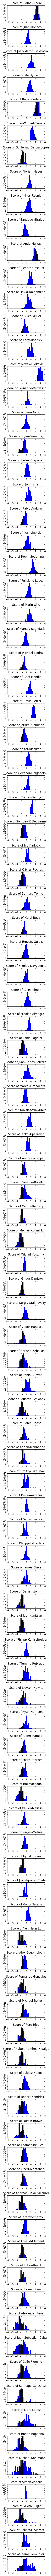

In [104]:
bins=40
fig, axes = plt.subplots(nrows=len(tennis_players), ncols=1, figsize=(3, 150))

for i in range(0, len(tennis_players)): 
    title = "Score of " + tennis_players[i]
    axes[i].set_title(title)
    axes[i].hist(mcmc.trace("score%i"%i)[:], bins=bins, range=(-4,4))
fig.subplots_adjust(hspace=6)
fig.tight_layout()

In [158]:
def p_of_win (player0_id, player1_id):
    score_diff = get_diff_by_id(player0_id,player1_id)
    return pymc.InvLogit("invLogit", score_diff)

In [171]:
def print_prediction(p0, p1):
    p = p_of_win(p0, p1);
    q = 1 - p
    try:
        print tennis_players[p0] + ": %f" % p + "\n" + str(tennis_players[p1]) + ": %f" % q + "\n"
    except KeyError:
        print "Paarung nicht gefunden"

In [176]:
print_prediction(3,4)


Mardy-Fish: 0.171349
Roger-Federer: 0.828651

